Model Calibration
=========

### This notebook is guiding through the calibration process of a catchment. The following steps are described in detail:
1. **Configuration of a calibration run**
2. **Running a calibration**
3. **Analyzing the calibration results**
4. **Post-processing:** Nash-Sutcliffe model efficiency coefficient (NSE) of the calibration and validation perid

<i>© Felix Matt, University of Oslo</i>

In [260]:
# python modules we use
%pylab inline
import os
import sys
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


##1. Configuration of a calibration run

* We use the **Calibrator**-object in orchestration2/shyft_runner.py to conduct a calibration
* The settings of a calibration are set in the calibration.yaml file. In this file...
    * the range of the calibration parameters are defined
    * the goal function and target time series are defined
    * the model configuration is defined by pointing to a model-configuration file, which is equal to the configuration.yaml file used for a regular simulation.

In [261]:
# setting up the environment
shyft_path = os.path.abspath(os.path.realpath('../hycamp/project_shyft/shyft'))
sys.path.append(shyft_path)

In [262]:
# importing all necessary functions from the shyft_runner.py file.
from shyft.orchestration2.shyft_runner import *

In [263]:
# set up the calibration configuration -> point to the calibration-config file
config_file = "./atnsjoen_catchment/calibration.yaml"
config_section = "atnsjoen"
config = CalibrationConfig(config_file, config_section)


In [264]:
# set up the simulator
calibrator = Calibrator(config)

In [265]:
# create a time axis
time_axis = api.Timeaxis(config.model_config.start_time, config.model_config.run_time_step, config.model_config.number_of_steps) 

##2. Running a calibration

In [266]:
# Initialize the calibrator
calibrator.init(time_axis)
calibrator.calibrator.set_verbose_level(1)

1 wind_speed series found.
4 radiation series found.
2 precipitation series found.
2 temperature series found.
1 relative_humidity series found.
Done with model setup/interpolation step
atnsjoen discharge [0]


In [267]:
# RUN THE CALIBRATION!
calibr_results = calibrator.calibrate(tol=1.0e-5)

Calibrating...


##3. Analyzing the calibration results

In [268]:
for key in calibr_results.keys():
    print '{:30}{}'.format(key, calibr_results[key])
    #print 'NSE: {:.2f}{}'.format(calibrator.calculate_goal_function(calibr_results))

wind_const                    1.0
max_albedo                    0.958723623027
p_corr_scale_factor           0.927193957312
fast_albedo_decay_rate        9.15436116059
TX                            -1.16383662543
glacier_albedo                0.4
surface_magnitude             30.0
snowfall_reset_depth          5.0
wind_scale                    2.95973962952
slow_albedo_decay_rate        35.895909797
ae_scale_factor               0.847930322415
c3                            -0.0374328293603
c2                            1.0
c1                            -3.0
snow_cv                       0.4
min_albedo                    0.414981692733
max_water                     0.1


In [269]:
# save the calibration results
calibrator.save_calibrated_model(config.calibrated_model_file, calibr_results)

Storing calibrated params in: /home/hub-felixmatt/shyft-course_day2/atnsjoen_catchment/model_calibrated.yaml


##4. Post processing

####For investigating the calibration quality, we rerun the model - now with the configuration.yaml pointing to the new model.yaml generated after the calibration. By doing this, the simulation will use the parameters obtained from the calibration.

In [270]:
# load modules we need for post-processing
from netCDF4 import Dataset
import numpy as np
import pandas as pd

In [271]:
# set up configuration
config_file = "./atnsjoen_catchment/configuration.yaml"
config_section = "atnsjoen"
run_config = config_constructor(config_file, config_section)

In [272]:
# set up the simulator
simulator = Simulator(run_config)

In [273]:
# create a time axis
time_axis = api.Timeaxis(run_config.start_time, run_config.run_time_step, run_config.number_of_steps)

In [274]:
# build the model
simulator.build_model(time_axis.start(), time_axis.delta(), time_axis.size())

1 wind_speed series found.
4 radiation series found.
2 precipitation series found.
2 temperature series found.
1 relative_humidity series found.
Done with model setup/interpolation step


In [275]:
# RUN THE MODEL!
simulator.run_model()

In [276]:
# get simulated time series
catchment_indeces=simulator.catchment_map
discharge_sim_obj = simulator.model.statistics.discharge(api.IntVector(0))
sim = [value for value in discharge_sim_obj.v]
sim_time = [discharge_sim_obj.time(i) for i in range(len(sim))]
sim_date = [datetime.datetime.utcfromtimestamp(t) for t in sim_time]

In [277]:
# load the discharge observations from file
with Dataset(config.target[0]['file']) as dset:
    catchment = dset.groups['atnsjoen']
    obs = catchment.variables['discharge'][:]
    obs_date = [datetime.datetime.utcfromtimestamp(t) for t in catchment.variables['time']]

In [278]:
# create Pandas Data Frame
sim_ts = pd.Series(sim, index=sim_date)
obs_ts = pd.Series(obs, index=obs_date)

df = pd.DataFrame({'sim':sim_ts, 'obs':obs_ts})

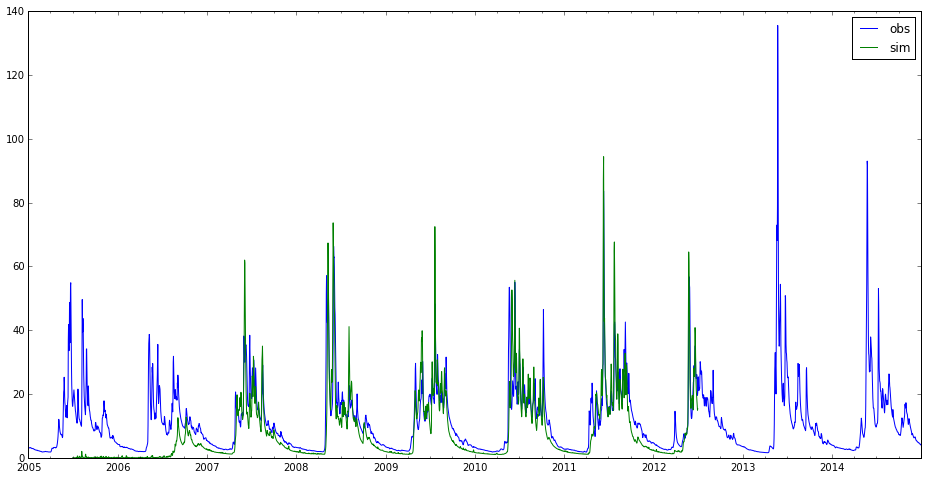

In [279]:
# Plotting of results
figure(figsize(16,8))
df.plot()

In [280]:
def NSE(df):
    # takes pandas dataframe with keys "obs" and "sim" and calculates Nash-Sutcliffe-Efficiency
    obs = np.array(df['obs'])
    sim = np.array(df['sim'])
    mean_obs = np.mean(obs)
    nom = np.sum((obs-sim)**2)
    denom = np.sum((obs-np.mean(obs))**2)
    return 1-nom/denom
    

In [281]:
# get datetime objects of calibration period
start_date = config.target[0]['1D_timeseries'][0]['start_datetime']
step = config.target[0]['1D_timeseries'][0]['run_time_step']
nr_of_steps = config.target[0]['1D_timeseries'][0]['number_of_steps']
end_date = start_date + datetime.timedelta(seconds=step*nr_of_steps)

In [282]:
# get NSE for the calibration period
start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')
start_str="2007-07-01"

print "NSE for the calibration period is {0:.2f}.".format(NSE(df[start_str:end_str]))

# NSE for a specific year
year = '2011'
print "NSE for the year {0:} is {1:.2f}.".format(year,NSE(df[year]))

NSE for the calibration period is 0.70.
NSE for the year 2011 is 0.75.


Exercise 1
======
Plot the result parmaters of the calibration above and compare with the parameter ranges set in the calibration.yaml file. Can you improve the calibration?

Exercise 2 - Model validation and verification
====

###Split-Sample validation
Use one part of the data for calibration (2007-07-01 until 2010-07-01) and the other
for validation (2009-07-01 until 2012-07-01). Save the calibration results and calculate the NSE for the calibration and validation period, respectively. Plot the simulated and the observed discharge.  Compare the calibrated model parameters to the parameters from the 5-year calibration.